<a href="https://colab.research.google.com/github/OumaymaRedissi/Personal-AI-trainer/blob/main/notebooks/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classification model** 

### Check and import lirabries/packages





**1. Checking packpage/libraries version**


In [ ]:
import sys 
import tensorflow

print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tensorflow.__version__}")

Python version: 3.9.16 (main, Dec  7 2022, 01:11:51) 
[GCC 9.4.0]
Tensorflow version: 2.12.0


**2. Import libraries**


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.keras.layers import SimpleRNN,Dense,Dropout
from tensorflow.python.keras import Sequential
from tensorflow import keras

# Get data from Google Drive

**3. Mount Drive**



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Testing**

In [ ]:
%cd /content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset_V1
%ls

/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset_V1
bad_back_round/  bad_head/         bad_shallow/  good/      train.json
bad_back_warp/   bad_inner_thigh/  bad_toe/      test.json  val.json


**4. Setup PATHS & VARIABLES** 

In [ ]:
# Define Path to the Dataset folder
BASE_PATH = '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset_V1'
VIDEOS_PATH = os.path.join(BASE_PATH,'**','*.mp4')
print(VIDEOS_PATH)

# Define LSTM sequence length and batch_size
SEQUENCE_LENGTH = 40
BATCH_SIZE = 16

/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset_V1/**/*.mp4


**5. Load data from files** 

In [ ]:
# Load the train data from the file
train_file = os.path.join(BASE_PATH, 'train.json')
with open(train_file) as f:
    train_data = json.load(f)
print("Length train data :",len(train_data))

# Load the test data from the file
test_file = os.path.join(BASE_PATH, 'test.json')
with open(test_file) as f:
    test_data = json.load(f)
print("Length test data :",len(test_data))

# Load the val data from the file
val_file = os.path.join(BASE_PATH, 'val.json')
with open(val_file) as f:
    val_data = json.load(f)
print("Length val data :",len(val_data))


Length train data : 1343
Length test data : 389
Length val data : 193


**5. Extract file paths and labels** 

In [ ]:
# Extract file paths and labels for train
train_file_paths = [d['file_path'] for d in train_data]
train_labels = [d['label'] for d in train_data]

# Extract file paths and labels for test
test_file_paths = [d['file_path'] for d in test_data]
test_labels = [d['label'] for d in test_data]

# Extract file paths and labels for val
val_file_paths = [d['file_path'] for d in val_data]
val_labels = [d['label'] for d in val_data]

In [ ]:
def convert_paths(paths, output_dir):
    new_paths = []
    for path in paths:
        path = path.strip()

        if not path:
            continue
        path = path.replace("\\", "/")
        # split the path into the directory and filename
        dir_path, filename = os.path.split(path)
        #print("1 dir_path: ",dir_path,"filename: ",filename)
        dir_path, folder = os.path.split(dir_path)
        #print("2 dir_path: ",dir_path,"folder: ",folder)
        filename = os.path.join(folder, filename)
        #print("3 filename: ",filename)

        # create the new output path
        new_output_path = os.path.join(output_dir, filename)

        # replace the backslashes with forward slashes
        new_paths.append(new_output_path)

    return new_paths

In [ ]:
output_dir = "/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/"
train_file_paths = convert_paths(train_file_paths, output_dir)
print(train_file_paths)
test_file_paths = convert_paths(test_file_paths, output_dir)
print(test_file_paths)

['/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_back_round/bad_squat_squat_bar_000008.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_back_round/bad_squat_squat_000049.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/good/1031_squat_000105.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_toe/1022_squat_000115.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_shallow/1029_squat_000033.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_head/1025_squat_000256.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_back_warp/1022_squat_000134.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/good/1106_squat_000002.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset/bad_toe/0922_squat_000024.json', '/content/drive/Othercomputers/PFE/PFE 2023/data/Keypoints_Dataset

In [ ]:
# Define a function to extract landmarks from a given file path
def extract_landmarks(file_path):
    with open(file_path) as f:
        landmarks = []
        data = json.load(f)
        for values in data.values():
            landmarks.append(values["landmarks"])
    return landmarks

In [ ]:
# Extract landmarks for train and test data
train_landmarks = [extract_landmarks(file_path) for file_path in train_file_paths]
test_landmarks = [extract_landmarks(file_path) for file_path in test_file_paths]

In [ ]:
def prepare_sequence_data(list_landmarks, num_videos, max_seq_len, seq_len, feature_dim):
  seq_array = np.zeros((num_videos, max_seq_len, seq_len, feature_dim))
  for i, video in enumerate(list_landmarks):
      for j, frame in enumerate(video):
          if len(frame) != 33:
              # Skip this frame if it doesn't have exactly 33 landmarks
              continue
          # Convert the landmarks to numpy array
          landmarks = np.array(frame)
          # Skip this frame if any landmark doesn't have 4 elements
          if landmarks.shape != (33, 4):
              continue
          # Pad the sequence with zeros if it is shorter than max_seq_len
          padded_seq = np.zeros((33, feature_dim))
          padded_seq[:len(frame), :] = landmarks
          seq_array[i, j, :, :] = padded_seq
  return seq_array
  # The resulting seq_array has shape (num_videos, max_seq_len, seq_len, feature_dim) 


In [ ]:
# Initialize the sequence array
#num_videos = len(train_landmarks)
seq_len = 33
feature_dim = 4
max_seq_len = 300

X_train = prepare_sequence_data(train_landmarks, len(train_landmarks), max_seq_len, seq_len, feature_dim)
y_train = np.array(train_labels)
X_test = prepare_sequence_data(test_landmarks, len(test_landmarks), max_seq_len, seq_len, feature_dim)
y_test = np.array(test_labels)


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1219, 300, 33, 4)
(1219,)
(409, 300, 33, 4)
(409,)


In [ ]:
# combine the width and height dimensions into a single input dimension
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]*X_train.shape[3]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]*X_test.shape[3]))


In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(1219, 300, 132)
(1219,)
(409, 300, 132)
(409,)


In [ ]:
print(X_train[0][0])
print(X_train[0][1])
print(X_train[0][2])
print(X_train[0][3])

[ 0.41706562  0.19104835 -0.00934901  0.99893385  0.4191151   0.17202821
  0.00193719  0.99860877  0.41848442  0.1707778   0.00190761  0.99808902
  0.41777653  0.16938737  0.00189343  0.99861479  0.41786176  0.17052415
 -0.03499675  0.99915516  0.41646031  0.16850883 -0.03504781  0.99924183
  0.41498551  0.16632363 -0.03510361  0.99944371  0.40410432  0.15845498
  0.06573073  0.99807632  0.39969036  0.15444002 -0.10239777  0.99895573
  0.4072924   0.2031498   0.01807419  0.99740076  0.40628403  0.1994389
 -0.03101812  0.99826068  0.36473075  0.22056147  0.15669383  0.99114746
  0.3475731   0.21836016 -0.16355559  0.99974614  0.35824639  0.30116567
  0.3042762   0.03346622  0.34083501  0.32509458 -0.28632298  0.94094008
  0.36534673  0.24082011  0.39740697  0.06438639  0.35739234  0.22104913
 -0.33346161  0.92287493  0.36235699  0.23362896  0.42165658  0.08892272
  0.35408959  0.19364786 -0.35362628  0.91491234  0.36475435  0.22172108
  0.41585284  0.09061244  0.34985429  0.18906206 -0.

In [ ]:
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Masking

model = tf.keras.Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(600, dropout=0.5, recurrent_dropout=0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

In [ ]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
20/20 [==============================] - 292s 14s/step - loss: 1.9886 - accuracy: 0.1649 - val_loss: 1.9544 - val_accuracy: 0.1540
Epoch 2/30
20/20 [==============================] - 286s 14s/step - loss: 1.9844 - accuracy: 0.1575 - val_loss: 1.9491 - val_accuracy: 0.1418
Epoch 3/30
 4/20 [=====>........................] - ETA: 4:10 - loss: 1.9886 - accuracy: 0.1484

KeyboardInterrupt: ignored

In [ ]:
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Masking

model = tf.keras.Sequential([
    Masking(mask_value=0., input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(600, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
    LSTM(300, dropout=0.5, recurrent_dropout=0.5, return_sequences=True),
    LSTM(150, dropout=0.5, recurrent_dropout=0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])


In [ ]:

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=30, validation_data=(X_test, y_test))

Epoch 1/30
 6/20 [========>.....................] - ETA: 5:53 - loss: 1.9771 - accuracy: 0.1562

In [ ]:
model = Sequential()
model.add(SimpleRNN(512, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(64, return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(32))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))





model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
20/20 [==============================] - 45s 2s/step - loss: 2.1711 - accuracy: 0.1354 - val_loss: 2.1134 - val_accuracy: 0.1540
Epoch 2/100
20/20 [==============================] - 40s 2s/step - loss: 2.2199 - accuracy: 0.1395 - val_loss: 1.9896 - val_accuracy: 0.1565
Epoch 3/100
20/20 [==============================] - 40s 2s/step - loss: 2.1091 - accuracy: 0.1436 - val_loss: 1.9489 - val_accuracy: 0.1516
Epoch 4/100
20/20 [==============================] - 40s 2s/step - loss: 2.0675 - accuracy: 0.1600 - val_loss: 1.9504 - val_accuracy: 0.1565
Epoch 5/100
20/20 [==============================] - 40s 2s/step - loss: 2.0977 - accuracy: 0.1403 - val_loss: 1.9550 - val_accuracy: 0.1565
Epoch 6/100
20/20 [==============================] - 42s 2s/step - loss: 2.0691 - accuracy: 0.1542 - val_loss: 1.9504 - val_accuracy: 0.1565
Epoch 7/100
20/20 [==============================] - 41s 2s/step - loss: 2.0835 - accuracy: 0.1477 - val_loss: 1.9465 - val_accuracy: 0.1589
Epoch 8/100
2

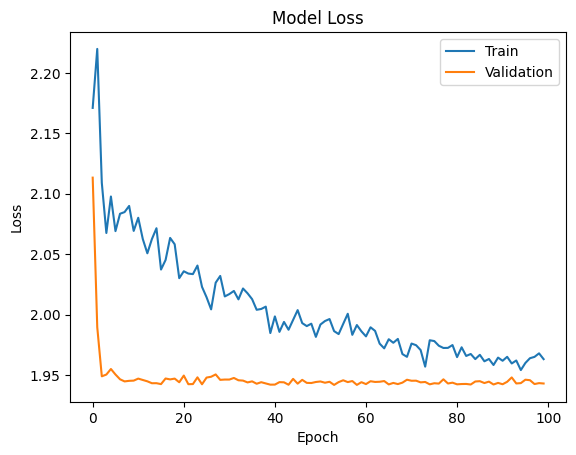

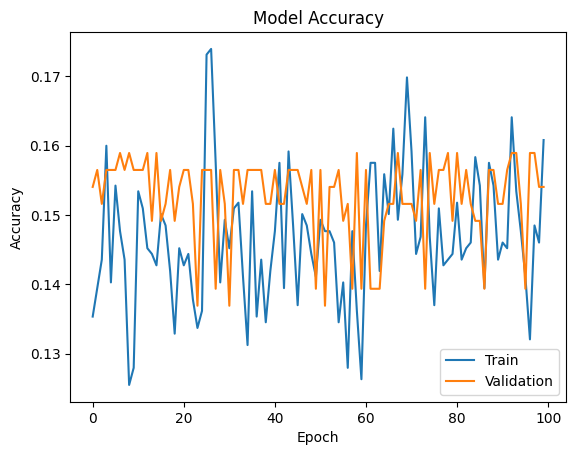

In [ ]:
# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()
